# Data exploration

## Import processing libraries

In [1]:
!pip install nltk wordcloud seaborn gensim tensorflow


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
import seaborn as sns
from collections import Counter
import string
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import os
from pickle import dump
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Load dataset

In [3]:
dataset_path = "./trainingandtestdata"
train_data_fb = "training.1600000.processed.noemoticon.csv"
df = pd.read_csv(dataset_path + "/" + train_data_fb, encoding="latin_1", names=['target', 'ids', 'date', 'flag', 'user', 'text'])
df.sample(5)

,target,ids,date,flag,user,text
1338118,4,2017958673,Wed Jun 03 09:12:53 PDT 2009,NO_QUERY,JRUD3Sx,I wanna see miley and metro station!
1496091,4,2070051885,Sun Jun 07 17:00:45 PDT 2009,NO_QUERY,zolexiy,Ð·Ð½ÑÑ? Ubuntu - ÑÐµÐ¿ÐµÑ Ð¼Ð°Ñ Debian Ð· ...
1230267,4,1991531991,Mon Jun 01 07:12:30 PDT 2009,NO_QUERY,Salehh,@Balty_5 @Mogz @MathieuWhite Thanks
668674,0,2246014624,Fri Jun 19 16:58:21 PDT 2009,NO_QUERY,_Electra_,@Mattdavelewis Why aren't you coming to Milan ...
541205,0,2200004588,Tue Jun 16 18:18:19 PDT 2009,NO_QUERY,Alice__Practice,"@enistar lol hey gurrrrrl, I haven't seen/talk..."


## Data quality

### General

In [4]:
print(f"Dataframe shape: {df.shape}")
print(f"Columns: {df.columns}")

Dataframe shape: (1600000, 6)
Columns: Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df['flag'].value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

Flag column does not contain any useful information. Let's drop this feature.

In [7]:
df = df.drop("flag", axis = 1)

Checking the labels. Convert them to binary.

In [8]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [9]:
df["target"] = df["target"].apply(lambda x: 0 if x == 0 else 1)

### Empty tweets

In [10]:
empty_tweets = df[df['text'].apply(lambda x: len(x)==0)]
print(f"Number of empty tweets: {len(empty_tweets.index)}")

Number of empty tweets: 0


### Duplicate data

In [11]:
duplicated_text = df[df['text'].duplicated(keep=False)]['text'].sort_values()
df.iloc[duplicated_text.index]

,target,ids,date,user,text
271472,0,1990023076,Mon Jun 01 03:37:19 PDT 2009,Jana1503,David must be hospitalized for five days end...
271505,0,1990029536,Mon Jun 01 03:38:42 PDT 2009,Jana1503,David must be hospitalized for five days end...
1132076,1,1975956610,Sat May 30 16:16:11 PDT 2009,DavidStocum,bathroom is clean..... now on to more enjoya...
1132074,1,1975956536,Sat May 30 16:16:11 PDT 2009,dstocum,bathroom is clean..... now on to more enjoya...
540159,0,2199656747,Tue Jun 16 17:49:00 PDT 2009,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
...,...,...,...,...,...
458170,0,2071810977,Sun Jun 07 19:57:37 PDT 2009,nancymack4,"zofran is not making this work day any easier,..."
464810,0,2175206707,Mon Jun 15 00:21:43 PDT 2009,Yukkaogebb,~ get SUICIDE !!
463926,0,2175018052,Sun Jun 14 23:52:55 PDT 2009,Yukkaogebb,~ get SUICIDE !!
1170868,1,1980423297,Sun May 31 06:42:03 PDT 2009,Tweetiebaby,~~~X0X0~~~!!!X0X0!!! I love you!!! &amp;...


We notice duplicated tweets.

We also see inconsistencies in labels such as indexes 1170868 and 238478. Let's first drop all row that contains the same text and a different target.

In [12]:
df_groupby_text = df.groupby(df['text'], as_index=False)['target'].mean()
inconsistency_filter = df_groupby_text['target'].apply(lambda x: x not in [0,1])
inconsistency_tweets_unique = df_groupby_text[inconsistency_filter]['text']
print(f"Number of unique inconsistent tweets: {inconsistency_tweets_unique.count()}")

Number of unique inconsistent tweets: 2225


In [13]:
inconsistency_tweets = df[df.apply(lambda x: x['text'] in inconsistency_tweets_unique.values, axis=1)]
print(f"Total number of inconsistent tweets: {len(inconsistency_tweets.index)}")

Total number of inconsistent tweets: 6895


In [14]:
df = df.drop(inconsistency_tweets.index)

We finally drop duplicated rows, even those with consistent targets.

In [15]:
df = df.drop_duplicates("text")

### Text length

target,0,1
mean,13.682093,12.810347


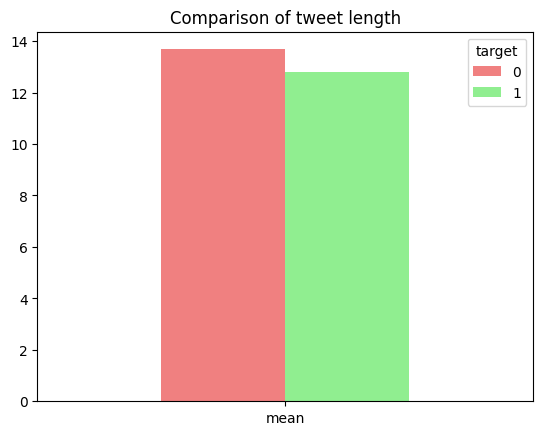

In [16]:
# Compare tweet length

df["tweet_length"] = df["text"].apply(lambda x: len(x.split()))
tweet_len = df.groupby(["target"]).agg(
   mean = ("tweet_length", "mean")
)
tweet_len = tweet_len.transpose()
tweet_len.plot(kind="bar", color = ("lightcoral", "lightgreen"), title="Comparison of tweet length", rot=0)
tweet_len

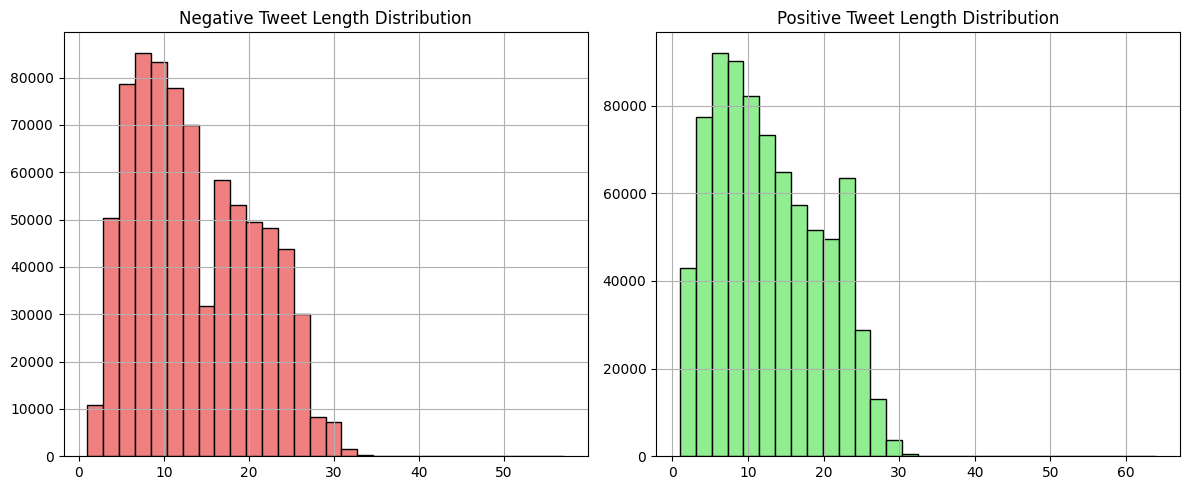

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df[df["target"]==0]["tweet_length"].hist(color="lightcoral", edgecolor="black", ax=axes[0], bins=30)
df[df["target"]==1]["tweet_length"].hist(color="lightgreen", edgecolor="black", ax=axes[1], bins=30)

axes[0].set_title("Negative Tweet Length Distribution")
axes[1].set_title("Positive Tweet Length Distribution")

plt.tight_layout()
plt.show()

### Labels balance

In [18]:
df["target"].value_counts()

target
1    791281
0    787960
Name: count, dtype: int64

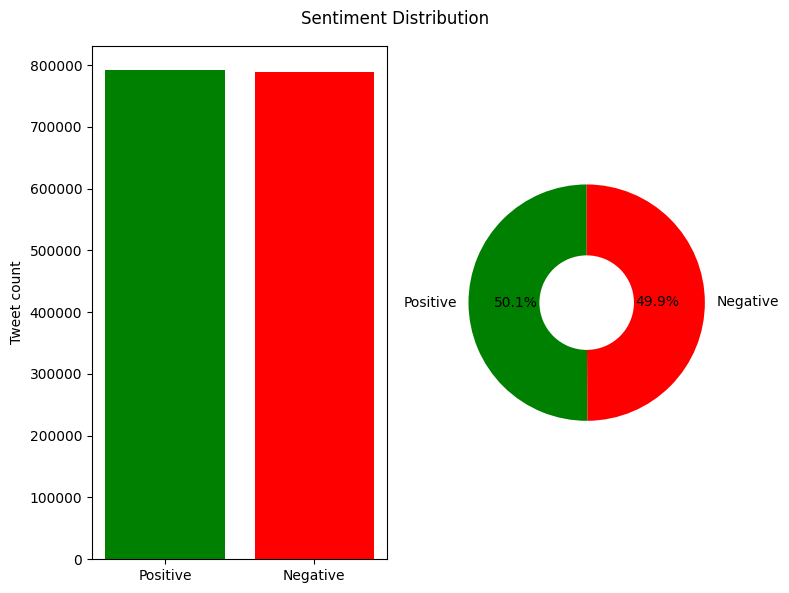

In [19]:
df_target = (
    df['target'].value_counts().to_frame(name='count').reset_index()
    .rename(columns={'index': 'target'})
)

# Convert 'target' to numeric (1 for positive, 0 for negative)
df_target['target'] = df_target['target'].replace(4, 1)

# Calculate user counts for positive and negative tweets
positive_tweets = df_target[df_target['target'] == 1]['count'].sum()
negative_tweets = df_target[df_target['target'] == 0]['count'].sum()

# Display visuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle('Sentiment Distribution')

# Pie chart of sentiment distribution in raw number
ax1.bar(['Positive', 'Negative'], [positive_tweets, negative_tweets], color=['green', 'red'])
ax1.set_ylabel('Tweet count')

# Pie chart of sentiment distribution in percentage
ax2.pie(
    [positive_tweets, negative_tweets],
    labels=['Positive', 'Negative'],
    autopct="%1.1f%%",
    startangle=90,
    colors=['green', 'red'],
    wedgeprops=dict(width=0.6)
)

# Tight layout for better overall plot arrangement
plt.tight_layout()

# Display the combined plot
plt.show()

The label are well distributed enough.

## Text cleaning

### Before cleaning

In [20]:
stop_words = set(stopwords.words('english'))

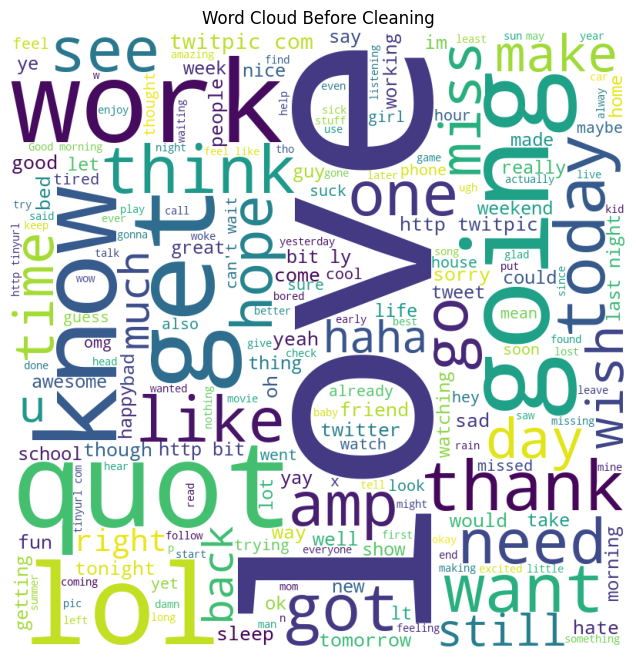

In [21]:
# Generate word cloud

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=stop_words,
                          min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

raw_dirty_text = ' '.join(df['text'])
generate_word_cloud(raw_dirty_text, 'Word Cloud Before Cleaning')

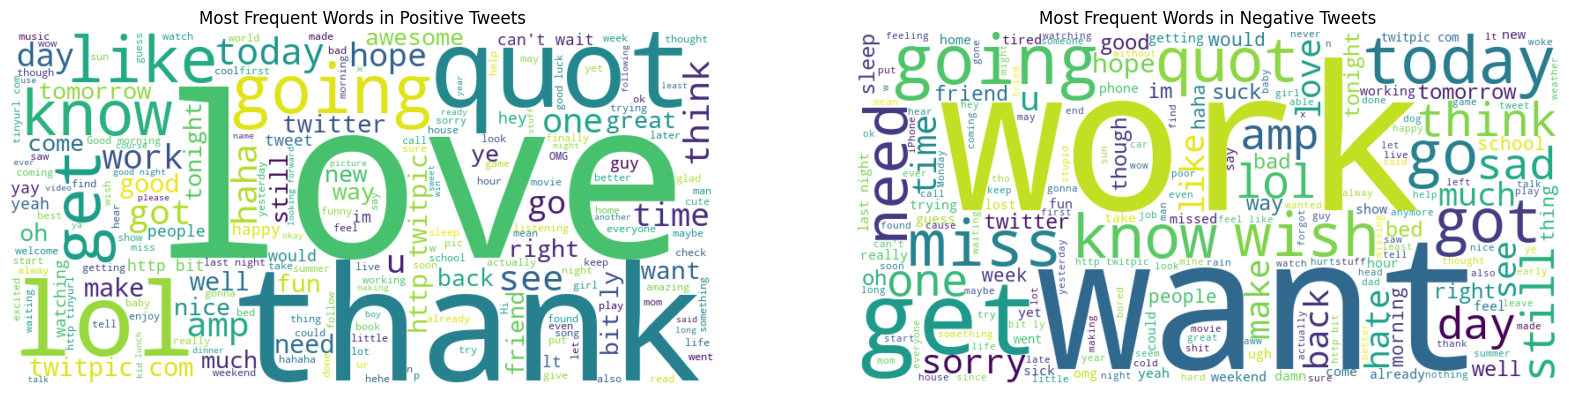

In [22]:
positive_words = " ".join(df[df["target"] == 1]["text"])
negative_words = " ".join(df[df["target"] == 0]["text"])

wordcloud_postitive = WordCloud(width=800, height=400, background_color="white", stopwords=stop_words).generate(positive_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color="white", stopwords=stop_words).generate(negative_words)

fig, axes = plt.subplots(1, 2, figsize=(20, 30))
axes[0].imshow(wordcloud_postitive, interpolation="bilinear")
axes[0].set_title("Most Frequent Words in Positive Tweets")
axes[0].axis("off")
axes[1].imshow(wordcloud_negative, interpolation="bilinear")
axes[1].set_title("Most Frequent Words in Negative Tweets")
axes[1].axis("off")
plt.show()

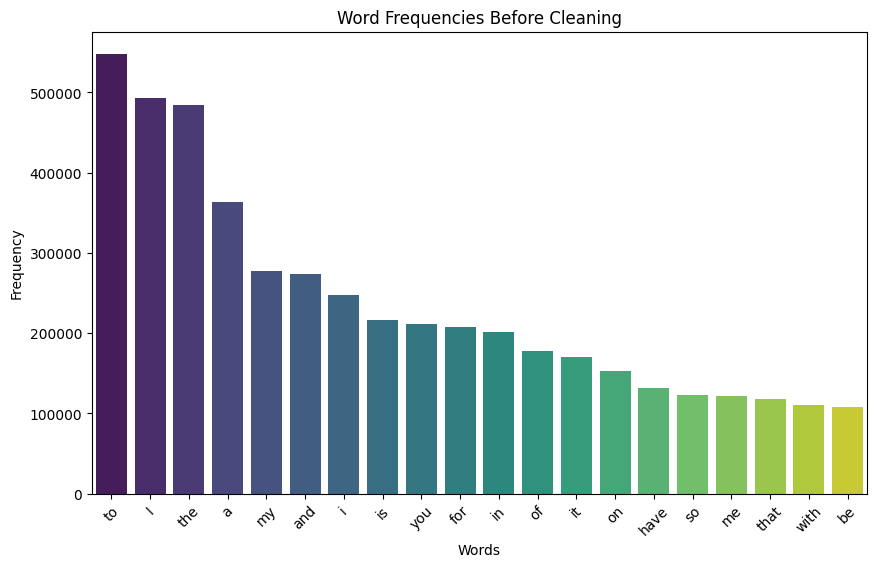

In [23]:
# Display bar plot of word frequencies

def plot_word_frequencies(text, title):
    word_freq = nltk.FreqDist(text.split())
    common_words = word_freq.most_common(20)
    words, freqs = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(freqs), hue=words, palette='viridis')
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_word_frequencies(' '.join(df['text']), 'Word Frequencies Before Cleaning')

There are words without much semantic meaning. We will need to clean them.

In [24]:
# Count special characters

raw_dirty_text_counter = Counter(raw_dirty_text)
non_letters_characters = raw_dirty_text_counter.keys() - list(string.ascii_letters)
print(f"List of non-letters characters: {non_letters_characters}")
print(f"Number of non-letters characters: {len(non_letters_characters)}")

List of non-letters characters: {'/', '\x89', '\x85', 'Ú', ':', '¯', '«', '\\', '{', '[', 'Ñ', '|', '.', 'í', 'Ä', '¡', '§', '\x9b', 'é', '\x97', '\x9c', '\x88', 'Å', '·', '8', '®', '\x9a', '\x9e', '3', '*', '¼', 'Ð', 'Ò', '\x93', '\x83', '}', '\x8e', '\x91', '×', 'à', '»', 'Ó', 'È', 'Í', '\x84', 'º', 'Ù', 'Î', '-', '\x94', 'Ì', '\x8a', '$', '°', '`', ')', '?', '¶', 'ß', 'µ', 'ï', '¹', 'Ë', 'ã', '\x7f', '9', '©', '\x87', '¦', ' ', '¿', 'Û', '¬', '\x99', '^', '@', 'Ç', 'â', '=', '\x86', 'Ï', '\x95', '£', '¥', '1', '\xad', '\x8c', '_', '%', '7', 'è', 'ë', '0', '\x8b', '&', 'Æ', '¢', '(', '!', '½', '2', '¤', '\x96', '¾', 'ê', '#', '6', '\t', '¨', '³', '´', '±', 'ª', 'Ø', '5', '+', '4', 'Ê', 'É', 'å', ';', 'ì', ']', '\x98', 'ç', '\x80', 'á', '\x92', '¸', 'î', '\x9f', '\x82', 'æ', 'Ã', '~', "'", ',', 'ä', 'Â', '\xa0', '²'}
Number of non-letters characters: 141


There are plenty of special characters. We will need to clean them.

### Cleaning

In [25]:
# Defining regex patterns and other text to be replaced

urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [26]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = ' '.join([w for w in tweet.split(" ") if len(w) > 2])
    tweet = re.sub(urlPattern,'URL',tweet)
    tweet = re.sub(userPattern, 'USER', tweet)
    tweet = re.sub(alphaPattern, " ", tweet)
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI_" + emojis[emoji])
    tweet = " ".join([WordNetLemmatizer().lemmatize(word) for word in tweet.split() if word not in stop_words])
    return tweet

df['text'] = df["text"].apply(clean_tweet)
df['text'] = df['text'].apply(lambda x: x.replace("im", ""))

### After cleaning

In [27]:
# Remove empty tweets after the cleaning process

empty_tweets = df[df['text'].apply(lambda x: len(x)==0)]
print(f"Number of empty tweets: {len(empty_tweets.index)}")
df.drop(empty_tweets.index, inplace=True)

Number of empty tweets: 575


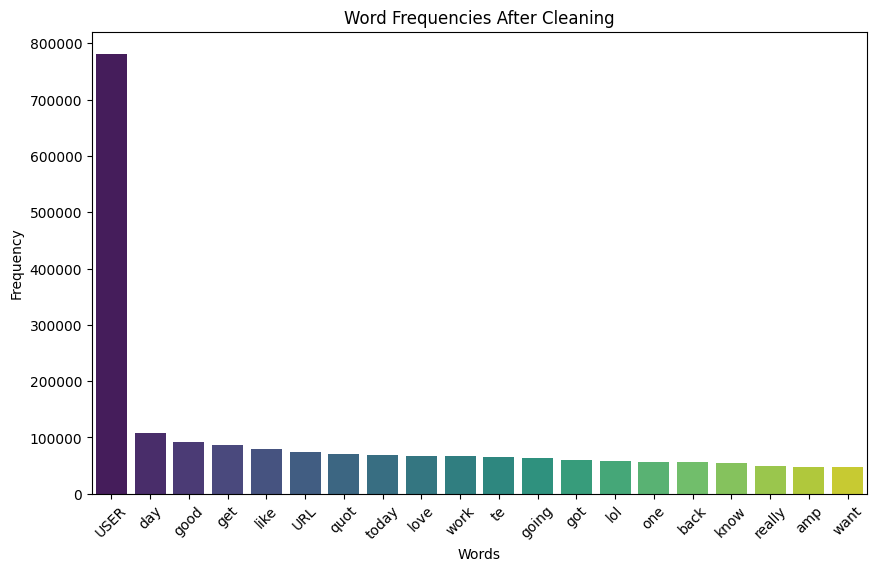

In [28]:
# Display bar plot of word frequencies

plot_word_frequencies(' '.join(df['text']), 'Word Frequencies After Cleaning')

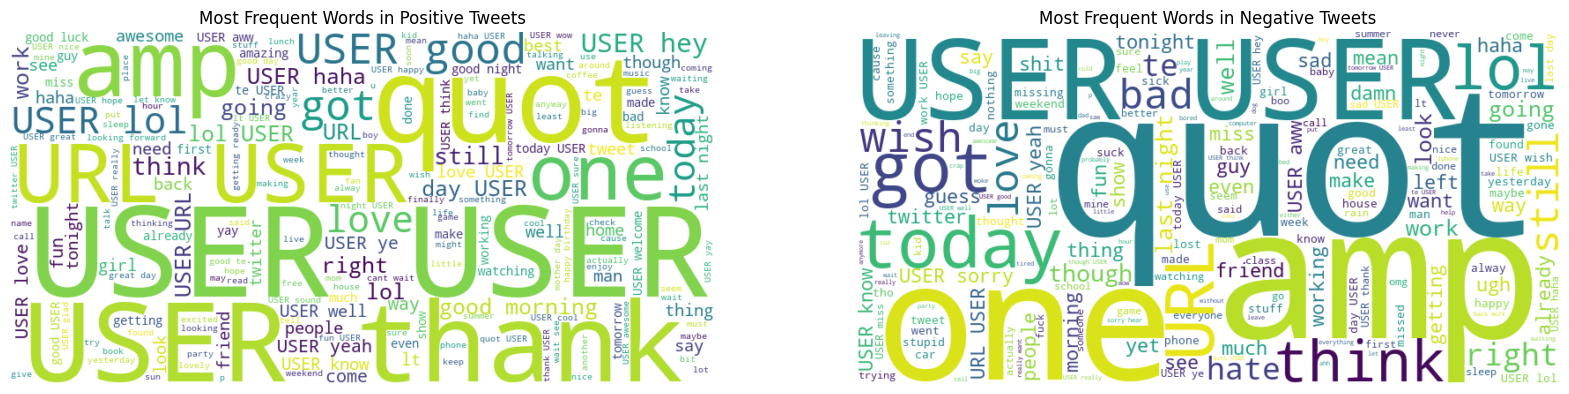

In [29]:
positive_words = " ".join(df[df["target"] == 1]["text"])
negative_words = " ".join(df[df["target"] == 0]["text"])

wordcloud_postitive = WordCloud(width=800, height=400, background_color="white").generate(positive_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color="white").generate(negative_words)

fig, axes = plt.subplots(1, 2, figsize=(20, 30))
axes[0].imshow(wordcloud_postitive, interpolation="bilinear")
axes[0].set_title("Most Frequent Words in Positive Tweets")
axes[0].axis("off")
axes[1].imshow(wordcloud_negative, interpolation="bilinear")
axes[1].set_title("Most Frequent Words in Negative Tweets")
axes[1].axis("off")
plt.show()

# Model training

## Logistic Regression

In [30]:
# Split dataset

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["target"], test_size = 0.05, random_state = 0)

In [31]:
# Define and execute training pipeline, evaluate model

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=500000)), ('model', LogisticRegression(C=2, max_iter=1000, n_jobs=-1))])
lr_pipeline.fit(X_train, y_train).score(X_test, y_test)

0.7951453112727088

In [32]:
# Save model

model_dir = "../models"
file_path = os.path.join(model_dir, "lr-pipeline.pkl")

os.makedirs(model_dir, exist_ok=True) # Create directory if it doesn't exist yet

with open(file_path, "wb") as f:
    dump(lr_pipeline, f, protocol=5)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     39244
           1       0.79      0.81      0.80     39690

    accuracy                           0.80     78934
   macro avg       0.80      0.80      0.80     78934
weighted avg       0.80      0.80      0.80     78934



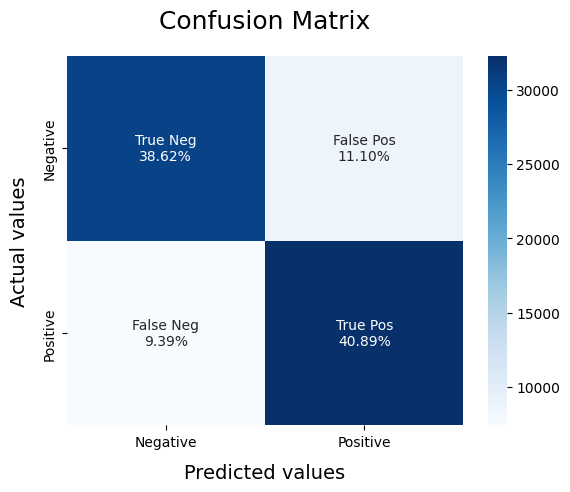

In [33]:
def model_evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

model_evaluate(lr_pipeline)

## LSTM

In [34]:
# Split dataset

X_data, y_data = np.array(df['text']), np.array(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.05, random_state = 0)
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1499732,)
X_test.shape : (78934,)


In [39]:
# Tokenize text (words > indices)

embedding_dim = max(len(sentence.split()) for sentence in X_data)
vocab_length = 50000
tokenizer = Tokenizer(num_words=vocab_length, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=embedding_dim)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=embedding_dim)
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1499732, 50)
X_test.shape : (78934, 50)


In [42]:
# Load an embedding model (words > dense vectors)

embedding_model = Word2Vec(sentences=list(map(lambda x: x.split(), X_data)), vector_size=embedding_dim, min_count=5)
mapping = embedding_model.wv
print("Vocabulary Length:", len(mapping.key_to_index))

Vocabulary Length: 45238


In [43]:
# Test embedding model

word = "example"
if word in mapping:
    vector = mapping[word]
    print(f"Vector for '{word}':", vector)
    similar_words = mapping.similar_by_vector(vector, topn=3)
    print(f"Closest vectors in embedding space:", similar_words)
else:
    print(f"'{word}' not found in the vocabulary!")

Vector for 'example': [ 0.22212978  0.45545867  0.03721565  0.19534414  0.11350352  0.35727257
 -0.06472147  0.16708623 -1.3663969   0.06014499 -0.48269862  0.10181671
 -0.17861894 -0.3581794   0.10356806 -0.5177453   1.4778886  -1.6426743
  0.72461605  0.8854613  -0.06295173  0.9937335   0.06181291 -0.0207721
 -0.5766203   1.0180758   0.91126704 -0.5946213   0.47843963  0.33668736
  1.7444254   0.64399076 -0.85271406  0.10413258  0.6123386   1.2498143
  0.1263215  -0.527335   -0.59208584 -1.9676899  -0.13002272  0.0082916
 -0.5532584  -0.2564718   1.2670231  -0.14211378 -0.5437635  -0.32460716
  0.5046962  -0.35504052]
Closest vectors in embedding space: [('example', 1.0000001192092896), ('approach', 0.8206996321678162), ('query', 0.8136650323867798)]


In [44]:
# Create embedding matrix (indices > dense vectors)

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, token in tokenizer.word_index.items():
    if mapping.__contains__(word):
        embedding_matrix[token] = mapping[word]

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (50000, 50)


In [47]:
# Define model

def getModel():
    model = Sequential([
        Embedding(input_dim=vocab_length,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=embedding_dim,
                  trainable=False),
        Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        Conv1D(50, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

lstm_model = getModel()
lstm_model.summary()

/opt/app-root/lib64/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-03-24 16:48:30.421519: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,500,000 (9.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,500,000 (9.54 MB)

In [ ]:
# Train model

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
             EarlyStopping(monitor='val_accuracy', patience=3, min_delta=1e-3)]

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_model.fit(
    X_train, y_train,
    batch_size=4096,
    epochs=3,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/3
 71/330 ━━━━━━━━━━━━━━━━━━━━ 2:24 557ms/step - accuracy: 0.6259 - loss: 0.6464

In [ ]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
# Predicting on the Test dataset.
y_pred = lstm_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [ ]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

In [ ]:
# Save model

model_dir = "../models"
file_path = os.path.join(model_dir, "lstm.keras")

os.makedirs(model_dir, exist_ok=True) # Create directory if it doesn't exist yet

lstm_model.save(file_path)